# LSTM pipeline for music lyrics emotion classification

This notebook implements a complete workflow for **multi-class text classification** of **song lyrics into emotions**. 

The pipeline includes: dataset loading, preprocessing, tokenization and padding, label encoding, model building (Bidirectional LSTM with embeddings), training with callbacks, evaluation (accuracy, classification report, confusion matrix), saving model artifacts, and demonstration of single-sample predictions.

**Workflow:**
1. **Imports & Configuration** – set random seeds, define constants, and configure paths.
2. **Dataset Loading** – read preprocessed lyrics and inspect class distribution.
3. **Dataset Preparation** – label encoding, splitting into train/val/test.
4. **Text Representation** – tokenization and padding of sequences.
5. **Model Architecture** – Bidirectional LSTM with embeddings, pooling, dense layers, and dropout.
6. **Training** – fit model with callbacks (early stopping, learning rate scheduling, checkpointing).
7. **Evaluation** – visualize learning curves, compute accuracy, classification report, confusion matrix.
8. **Saving Artifacts** – store model, tokenizer, and label encoder for reuse.
9. **Inference Demo** – run predictions on sample lyrics.


In [1]:
import random
import pickle
import json
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalMaxPooling1D

%matplotlib inline

In [ ]:
# ------------------------
# Config - hyperparameters
# ------------------------
SEED = 42
MAX_WORDS = 20000     # size of vocabulary
MAX_LEN = 128         # max tokens per lyric
EMBED_DIM = 100
LSTM_UNITS = 64
DENSE_UNITS = 32
DROPOUT = 0.3
BATCH_SIZE = 64
EPOCHS = 8
TEST_SIZE = 0.2

# ------------------------
# Paths
# ------------------------
PROJECT_ROOT = Path.cwd().parents[1]
DATA_PATH = PROJECT_ROOT / "data" / "processed" / "preprocessed_lyrics.csv"
OUT_DIR = PROJECT_ROOT / "models" / "lstm" / "outputs"
OUT_DIR.mkdir(exist_ok=True)

# Output files
MODEL_PATH = OUT_DIR / "lstm_model.keras"
TOKENIZER_PATH = OUT_DIR / "tokenizer.pkl"
LABEL_ENCODER_PATH = OUT_DIR / "label_encoder.pkl"
METADATA_PATH = OUT_DIR / "split_metadata.json"

# Add project root to Python path (for local utils)
sys.path.append(str(PROJECT_ROOT))


In [13]:
# ----------------------------
# Helpers: seeding & plotting
# ----------------------------
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed()

def plot_training(history):
    hist = history.history
    epochs = range(1, len(hist['loss'])+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, hist['loss'], label='train_loss')
    if 'val_loss' in hist:
        plt.plot(epochs, hist['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    acc_key = 'accuracy' if 'accuracy' in hist else 'acc'
    if acc_key in hist:
        plt.plot(epochs, hist[acc_key], label='train_acc')
        if f'val_{acc_key}' in hist:
            plt.plot(epochs, hist[f'val_{acc_key}'], label='val_acc')
        plt.title('Accuracy')
        plt.legend()
    plt.tight_layout()
    plt.show()


def print_classification_report(y_true, y_pred, class_names):
    """Print accuracy and classification report."""
    acc = accuracy_score(y_true, y_pred)
    print(f"Test accuracy: {acc:.4f}")
    print(classification_report(y_true, y_pred, target_names=class_names))


def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot normalized confusion matrix."""
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=class_names,
                yticklabels=class_names, cmap='Blues', annot_kws={"size": 10})
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()


def plot_overall_metrics(y_true, y_pred):
    """Plot overall accuracy, macro F1 and weighted F1 as bar chart."""
    test_acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')

    metrics = [test_acc, macro_f1, weighted_f1]
    labels = ['Accuracy', 'Macro F1', 'Weighted F1']

    plt.figure(figsize=(6,4))
    sns.barplot(x=labels, y=metrics, hue=labels, palette="Set2", dodge=False)
    plt.ylim(0, 1)
    plt.title("Test Set Metrics")
    for i, v in enumerate(metrics):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
    plt.show()


def plot_f1_per_class(y_true, y_pred, class_names):
    """Plot F1 score per class as bar chart."""
    f1_per_class = f1_score(y_true, y_pred, average=None)
    ax = sns.barplot(x=class_names, y=f1_per_class, hue=class_names, palette="Set2", dodge=False)
    plt.ylim(0, 1)
    plt.ylabel("F1 Score")
    plt.title("F1 Score by classes (Test set)")
    for bar, f1 in zip(ax.patches, f1_per_class):
        ax.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.02,
                f"{f1:.2f}",
                ha='center', va='bottom', fontsize=10)
    plt.show()


def plot_roc_curves(y_true, y_prob, class_names):
    """Plot ROC curves for each class."""
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_curve, auc
    
    num_classes = len(class_names)
    y_bin = label_binarize(y_true, classes=range(num_classes))
    
    fpr, tpr, roc_auc = {}, {}, {}
    plt.figure(figsize=(8,6))
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
    
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves per Class")
    plt.legend()
    plt.show()


def plot_precision_recall_curves(y_true, y_prob, class_names, min_samples=0):
    """Plot Precision-Recall curves per class, optionally filtering classes by min_samples."""
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import precision_recall_curve, average_precision_score
    import numpy as np
    
    num_classes = len(class_names)
    y_bin = label_binarize(y_true, classes=range(num_classes))
    
    if min_samples > 0:
        class_counts = np.bincount(y_true)
        valid_classes = [i for i, c in enumerate(class_counts) if c >= min_samples]
    else:
        valid_classes = range(num_classes)
    
    precision, recall, avg_prec = {}, {}, {}
    plt.figure(figsize=(8,6))
    
    for i in valid_classes:
        precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_prob[:, i])
        avg_prec[i] = average_precision_score(y_bin[:, i], y_prob[:, i])
        plt.plot(recall[i], precision[i], label=f"{class_names[i]} (AP = {avg_prec[i]:.2f})")
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall by Class")
    plt.legend()
    plt.show()


In [4]:
# -----------------------------------
# 1. Data Splitting & Label Encoding
# -----------------------------------
from utils.splitter import DataSplitter
splitter = DataSplitter(str(DATA_PATH)).load_data().create_splits(train_size=0.8, val_size=0.1, test_size=0.1)

train_texts, train_labels = splitter.get_split_for_pytorch("train")
val_texts, val_labels     = splitter.get_split_for_pytorch("val")
test_texts, test_labels   = splitter.get_split_for_pytorch("test")

# Save metadata
with open(METADATA_PATH, 'w') as f:
    json.dump({
        'class_names': list(splitter.label_encoder.classes_),
        'num_train': len(train_texts),
        'num_val': len(val_texts),
        'num_test': len(test_texts)
    }, f, indent=2)

Loading data from e:\RI Projekat\music_lyrics_classification\data\processed\preprocessed_lyrics.csv
Dataset loaded: 551,398

Emotion distribution in full dataset:
  joy: 209,003 samples (0.379)
  sadness: 171,071 samples (0.310)
  anger: 109,673 samples (0.199)
  fear: 28,096 samples (0.051)
  love: 27,963 samples (0.051)
  surprise: 5,592 samples (0.010)

=== Split Statistics ===
TRAIN SET: 441,118 samples
  joy: 167,202 (0.379)
  sadness: 136,857 (0.310)
  anger: 87,738 (0.199)
  fear: 22,476 (0.051)
  love: 22,371 (0.051)
  surprise: 4,474 (0.010)
VAL SET: 55,140 samples
  joy: 20,900 (0.379)
  sadness: 17,107 (0.310)
  anger: 10,968 (0.199)
  fear: 2,810 (0.051)
  love: 2,796 (0.051)
  surprise: 559 (0.010)
TEST SET: 55,140 samples
  joy: 20,901 (0.379)
  sadness: 17,107 (0.310)
  anger: 10,967 (0.199)
  fear: 2,810 (0.051)
  love: 2,796 (0.051)
  surprise: 559 (0.010)


In [5]:
# ------------------------
# 2. Tokenizer + padding
# ------------------------
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<UNK>")
tokenizer.fit_on_texts(train_texts)  # fit only on train

X_train_pad = pad_sequences(tokenizer.texts_to_sequences(train_texts), maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad   = pad_sequences(tokenizer.texts_to_sequences(val_texts),   maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad  = pad_sequences(tokenizer.texts_to_sequences(test_texts),  maxlen=MAX_LEN, padding='post', truncating='post')

y_train = np.array(train_labels)
y_val   = np.array(val_labels)
y_test  = np.array(test_labels)

# Save tokenizer and label encoder
with open(TOKENIZER_PATH, 'wb') as f:
    pickle.dump(tokenizer, f)

with open(LABEL_ENCODER_PATH, 'wb') as f:
    pickle.dump(splitter.label_encoder, f)


In [6]:
# ------------------------
# 3. Class weights
# ------------------------
class_weights = splitter.compute_class_weights(method='inverse', use_split='train')
weights_for_tf = {idx: float(weight) for idx, weight in enumerate(class_weights.values())}

In [7]:
# ------------------------
# 4. Build LSTM Model
# ------------------------
num_classes = len(splitter.label_encoder.classes_)

model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBED_DIM),
    Bidirectional(LSTM(LSTM_UNITS, return_sequences=True, dropout=0.3)),
    GlobalMaxPooling1D(),
    Dense(DENSE_UNITS, activation='relu'),
    Dropout(DROPOUT),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=1, verbose=1),
    ModelCheckpoint(str(MODEL_PATH), monitor='val_accuracy', save_best_only=True, verbose=1)
]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
# ------------------------
# 5. Train model
# ------------------------
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=weights_for_tf,
    verbose=1
)

Epoch 1/8
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.4629 - loss: 1.3669
Epoch 1: val_accuracy improved from None to 0.61277, saving model to e:\RI Projekat\music_lyrics_classification\outputs\lstm_model.keras
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 1783s 258ms/step - accuracy: 0.5329 - loss: 1.1977 - val_accuracy: 0.6128 - val_loss: 1.0934 - learning_rate: 0.0010
Epoch 2/8
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.6096 - loss: 1.0120
Epoch 2: val_accuracy improved from 0.61277 to 0.63491, saving model to e:\RI Projekat\music_lyrics_classification\outputs\lstm_model.keras
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 1661s 241ms/step - accuracy: 0.6165 - loss: 0.9983 - val_accuracy: 0.6349 - val_loss: 1.0297 - learning_rate: 0.0010
Epoch 3/8
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.6337 - loss: 0.9344
Epoch 3: val_accuracy improved from 0.63491 to 0.64755, saving model to e:\RI Projekat\music_lyrics_classification\outputs\lstm_model.keras
6893/6893 ━━━━━━━━━━

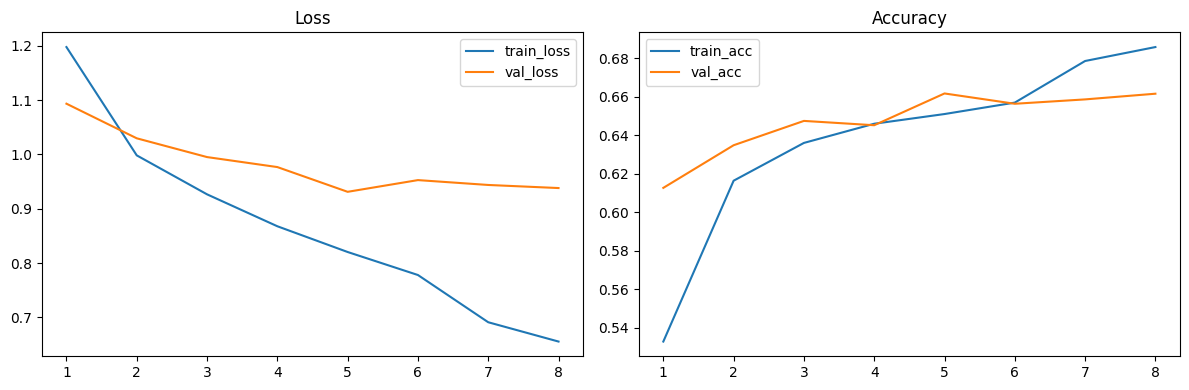

In [9]:
plot_training(history)

In [10]:
# ------------------------
# 6. Evaluate model
# ------------------------
best_model = load_model(MODEL_PATH)
best_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

y_prob = best_model.predict(X_test_pad, batch_size=BATCH_SIZE, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
class_names = splitter.label_encoder.classes_

print_classification_report(test_labels, y_pred, class_names)

862/862 ━━━━━━━━━━━━━━━━━━━━ 64s 74ms/step
Test accuracy: 0.6613
              precision    recall  f1-score   support

       anger       0.64      0.63      0.64     10967
        fear       0.39      0.62      0.48      2810
         joy       0.75      0.67      0.70     20901
        love       0.42      0.71      0.53      2796
     sadness       0.75      0.67      0.71     17107
    surprise       0.31      0.67      0.42       559

    accuracy                           0.66     55140
   macro avg       0.54      0.66      0.58     55140
weighted avg       0.69      0.66      0.67     55140



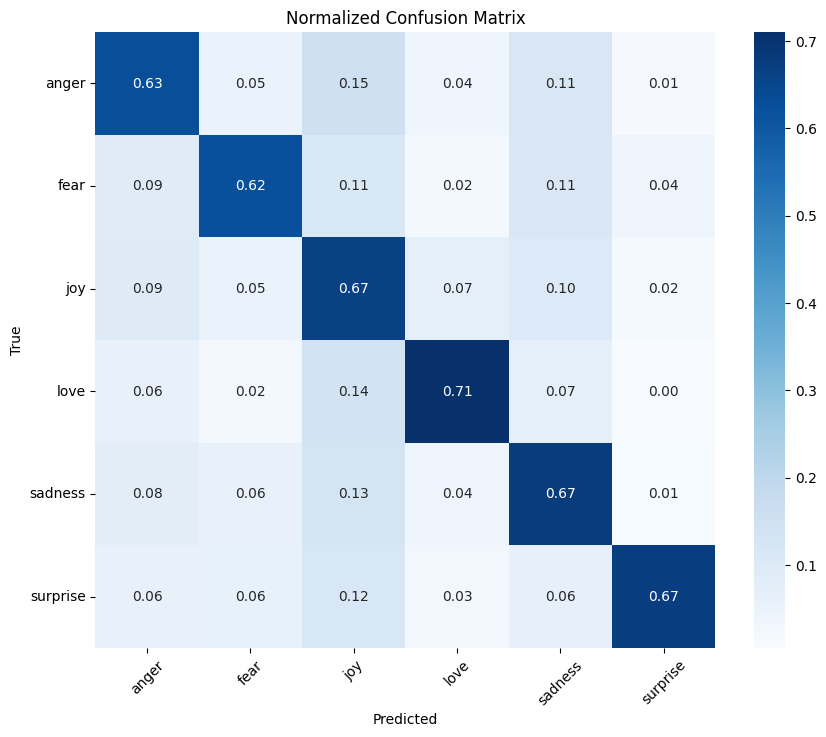

In [11]:
plot_confusion_matrix(test_labels, y_pred, class_names)

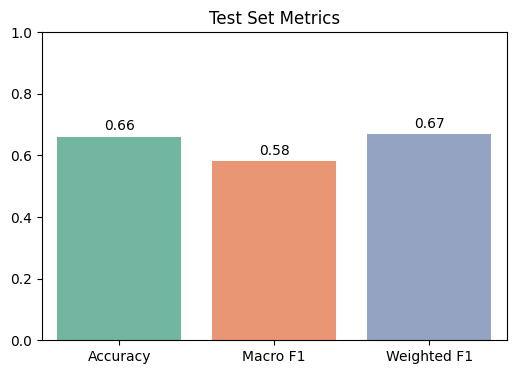

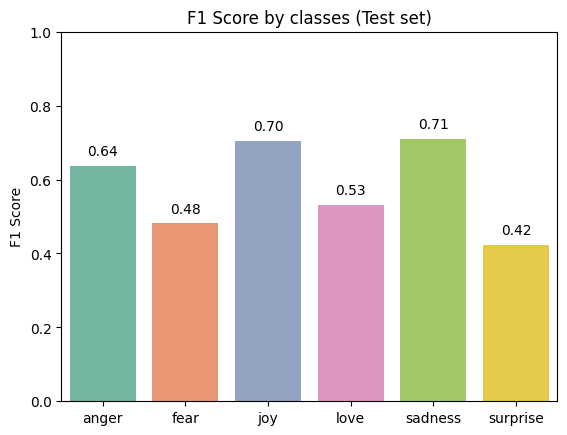

In [14]:
plot_overall_metrics(test_labels, y_pred)
plot_f1_per_class(test_labels, y_pred, class_names)

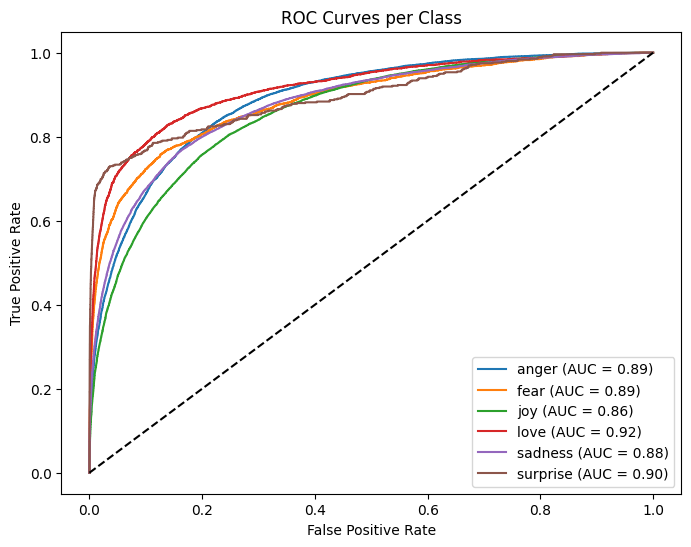

In [15]:
plot_roc_curves(test_labels, y_prob, class_names)

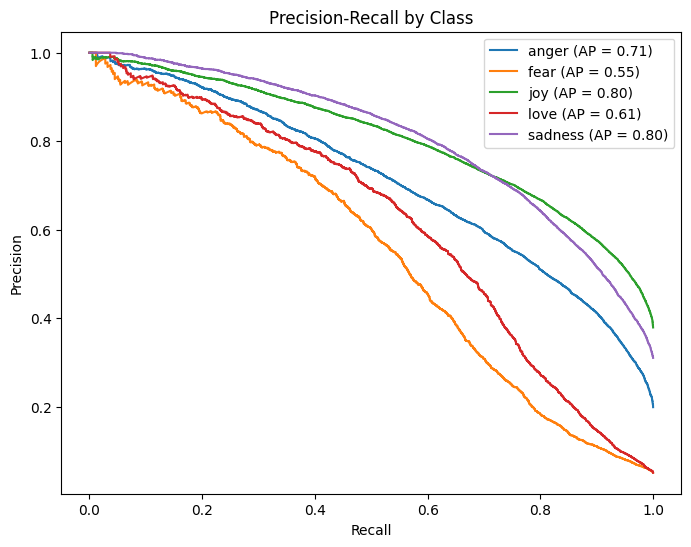

In [16]:
plot_precision_recall_curves(test_labels, y_prob, class_names, min_samples=2500)

In [20]:
# ----------------------------
# 7. Single prediction helper
# ----------------------------
def predict_single(text: str):
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')
    prob = best_model.predict(pad, verbose=0)[0]
    pred_idx = prob.argmax()
    pred_label = splitter.label_encoder.inverse_transform([pred_idx])[0]
    return pred_label, prob

# Show 10 random examples
indices = random.sample(range(len(test_texts)), min(10, len(test_texts)))
for i in indices:
    txt = test_texts[i]
    true_lbl = splitter.label_encoder.inverse_transform([test_labels[i]])[0]
    pred_lbl, prob = predict_single(txt)
    print("----")
    print("Text snippet:", txt[:200].replace("\n"," ") + "...")
    print("True:", true_lbl, "Pred:", pred_lbl, f"(prob {prob.max():.3f})")

----
Text snippet: i told you that i loved you and i meant it then you know i'd never lie to you i do not pretend so do not make up that this was a fake love i told you that i will always care you laugh out loud i try t...
True: joy Pred: love (prob 0.798)
----
Text snippet: merry christmas have a very very merry christmas dream about your heart's desire christmas eve when you retire santa claus will stop and i know he will drop exactly what you wanted from your chimney t...
True: joy Pred: joy (prob 0.999)
----
Text snippet: first go like this spin around stop doubletake three times one two three now it is time to bring it around town yeah yeah on the beat bring it around yeah show me how you move how you get down yeah go...
True: joy Pred: joy (prob 0.439)
----
Text snippet: vengeance is the lord's but i am feelin' like a god today i'mma hit 'em up yeah i am feelin' like pac today these ambitions of a ridah i do not see no changes live and die in la is leaving brendas hel...
True: jo